# Reinforcement Learning

The final method thought of without requiring to worry about non-differentiable qiskit Circuit would be to use reinforcement learning to learn. However, this would be very difficult especially most online tutorials are based on OpenAI Gym and other pre-built libraries available with the pre-built environments. And building own environment, worse still, an environment of qiskit circuit instead of games, is a nightmare. 

Trying our best to implement if possible. 

The code is takened based on: https://github.com/shivaverma/Orbit/blob/master/Paddle/

In [5]:
import qiskit.tools.jupyter
%qiskit_version_table

In [6]:
import qiskit
from qiskit import *
from qiskit.compiler import assemble
from qiskit.visualization import plot_histogram


import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from collections import deque
from tqdm import tqdm

In [7]:
shots = 6000
number = 1

# Equality means what are the number to get 0.5 probability for each. 
# equality = shots / np.power(2, number)

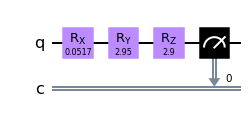

In [8]:
qc = QuantumCircuit(number, number)

rng = np.random.default_rng()

qc.rx(rng.random() * np.pi, 0)
qc.ry(rng.random() * np.pi, 0)
qc.rz(rng.random() * np.pi, 0)

qc.measure(range(number), range(number))
qc.draw("mpl")

In [9]:
backend = Aer.get_backend("aer_simulator")
circ = transpile(qc, backend)

qobj = assemble(circ, shots=shots)

# Run and get counts
result = backend.run(qobj).result()
result = result.get_counts()
result

{'0': 55, '1': 5945}

In [10]:
target = {"0": int(shots * 0.3), "1": int(shots * 0.7)}
target

{'0': 1800, '1': 4200}

In [11]:
penalty = 0
len_keys = len(result.keys())

for i in result.keys():
    # Root mean squared error
    curr_penalty = np.square( (target[i] - result[i]) / shots ) / len_keys
    penalty += np.sqrt(curr_penalty)

penalty

0.41130044439017516

In [12]:
min(penalty, 2.5)

0.41130044439017516

Reinforcement learning function starting below. 

In [18]:
class Qiskit_env():
    
    def __init__(self, target=target, tolerance=0.05):
        """
        :var target: (dict) What do you want the result of the qiskit circuit to be? 
        :var tolerance: (float) What is the root mean squared error that you can tolerate? 
        """
        self.done = False
        self.reward = 10  # To prevent extreme punishment in the beginning (only). This can be tuned. 
        self.hit, self.miss = 0, 0
        self.backend = Aer.get_backend('aer_simulator')
        
        # Setup Qiskit Circuit
        self.previous = shots * 2  # some random large number. 
        self.qc = QuantumCircuit(number, number)
        self.target = target
        
        self.value = rng.random()
        self.rank = 0
        
        self.counts = 0
        self.penalty = 0
        self.tolerance = tolerance
        
    def increase_val(self):
        """
        Ability to increment current gate angle value.
        """
        x = self.value
        
        # Usually will want 2 * np.pi - 0.01 * np.pi but just to make me not confuse. 
        # Plus it would not lead to invalid value, just overshoot and repeat what
        # range we have. So we can savely proceed. 
        
        if x < 2 * np.pi:
            self.value += 0.01
            
            
    def decrease_val(self):
        """
        Ability to decrement current gate angle value.
        """
        x = self.value
        
        # Same explanation as before. 
        
        if x > 0:
            self.value -= 0.01

    def increase_rank(self):
        """
        Ability to move horizontally between Rx, Ry and Rz. 
        """
        self.rank = (self.rank + 1) % 3

    def decrease_rank(self):
        """
        Ability to move horizontally to the left between Rx, Ry and Rz gate.
        """
        self.rank = (self.rank - 1) % 3
            
            
    def run_frame(self):
        self.penalty = 0
        
        self.qc = QuantumCircuit(number, number)

        self.qc.rx(self.value * np.pi, 0)
        self.qc.ry(self.value * np.pi, 0)
        self.qc.rz(self.value * np.pi, 0)
            
        self.qc.measure(range(number), range(number))
        
        circ = transpile(self.qc, self.backend)

        qobj = assemble(circ, shots=shots)

        # Run and get counts
        result = self.backend.run(qobj).result()
        self.counts = result.get_counts()

        for i in self.counts.keys():
            # Root mean squared error
            curr_penalty = np.square( (self.target[i] - self.counts[i]) / shots ) / len(self.counts.keys())
            self.penalty += np.sqrt(curr_penalty)
        
        # Doing bad job
        if self.penalty > self.previous:
            self.reward -= min(abs(self.penalty - self.previous), 2.5)
            
        # Doing good job
        if self.penalty <= self.previous:
            self.reward += min(abs(self.penalty - self.previous), 2.5)      
            
        # End of story
        if (self.penalty) <= self.tolerance:
            self.done = True
            
        self.previous = self.penalty
            
    def reset(self):
        return [self.value]
    
    def step(self, action):
        self.reward = 0
        self.done = 0
        
        if action == 0:
            self.increase_val()
            self.reward -= 0.01
            
        if action == 2:
            self.decrease_val()
            self.reward -= 0.01

        if action == 3:
            self.increase_rank()
            self.reward -= 0.01

        if action == 4:
            self.decrease_rank()
            self.reward -= 0.01
            
        self.run_frame()
        
        state = [self.value]
        return self.reward, state, self.done
        

In [19]:
env = Qiskit_env()

In [20]:
class DQN:
    """Implementation of Deep Q learning algorithm. """
    
    def __init__(self, action_space, state_space):
        
        self.action_space = action_space
        self.state_space = state_space
        self.epsilon = 1
        self.gamma = 0.95
        self.batch_size = 32  # Not sure how this will affect training. 
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.memory = deque(maxlen=10000)  # Increase if you have larger RAM.
        self.model = self.build_model()
        
        
    def build_model(self):
        model = tf.keras.Sequential()
        model.add(layers.Dense(64, input_shape=(self.state_space,), activation="relu"))
        model.add(layers.Dense(64, activation="relu"))
        model.add(layers.Dense(self.action_space, activation="linear"))
        
        model.compile(loss="mse", optimizer=tf.optimizers.Adam(learning_rate=self.learning_rate))
        
        return model
    
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)
        
        act_values = self.model.predict(state)
        
        return np.argmax(act_values[0])
    
    def replay(self):

        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        targets = rewards + self.gamma*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)

        ind = np.array([i for i in range(self.batch_size)])
#         print(targets_full[[ind], [actions]])
        targets_new = np.empty((self.batch_size, self.action_space))
        targets_new[[ind], [actions]] = targets

        self.model.fit(states, targets_new, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

We will not implement Action 4 and 5 yet as we still want to find out how to let the model take 2 action at a time, if required. So it not only learns to increase and decrease the rank and value at the same time instead of able to do one thing at once only. 

In [23]:
def train_dqn(episode):
    loss = []
    
    action_space = 3  # Action space 4, 5 not yet implemented due to compatibility issue. 
    state_space = 1
    max_steps = 1000
    
    agent = DQN(action_space, state_space)
    
    for e in range(episode):
        state = env.reset()
        
        state = np.reshape(state, (1, state_space))
        score = 0
        
        for i in tqdm(range(max_steps)):
            action = agent.act(state)
            reward, next_state, done = env.step(action)
            
            score += reward
            next_state = np.reshape(next_state, (1, state_space))
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.replay()
            
            if done:
                print("episode: {}/{}, score: {}".format(e, episode, score))
                break
                
        loss.append(score)
        
    return loss

In [ ]:
ep = 500
loss = train_dqn(ep)

 27%|██▋       | 266/1000 [00:23<01:10, 10.36it/s]

In [ ]:
plt.figure(dpi=150)
plt.plot([i for i in range(ep)], loss)
plt.xlabel('episodes')
plt.ylabel('reward')